In [1]:
import scipy.io as sio
import numpy as np

In [2]:
def mat2dict(filename):
    """Converts MoVi mat files to a python nested dictionary.
    This makes a cleaner representation compared to sio.loadmat
    Arguments:
        filename {str} -- The path pointing to the .mat file which contains
        MoVi style mat structs
    Returns:
        dict -- A nested dictionary similar to the MoVi style MATLAB struct
    """
    # Reading MATLAB file
    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)

    # Converting mat-objects to a dictionary
    for key in data:
        if key != "__header__" and key != "__global__" and key != "__version__":
            if isinstance(data[key], sio.matlab.mio5_params.mat_struct):
                data_out = matobj2dict(data[key])
    return data_out


def matobj2dict(matobj):
    """A recursive function which converts nested mat object
    to a nested python dictionaries

    Arguments:
        matobj {sio.matlab.mio5_params.mat_struct} -- nested mat object

    Returns:
        dict -- a nested dictionary
    """
    ndict = {}
    for fieldname in matobj._fieldnames:
        attr = matobj.__dict__[fieldname]
        if isinstance(attr, sio.matlab.mio5_params.mat_struct):
            ndict[fieldname] = matobj2dict(attr)
        elif isinstance(attr, np.ndarray) and fieldname == "move":
            for ind, val in np.ndenumerate(attr):
                ndict[
                    fieldname
                    + str(ind).replace(",", "").replace(")", "").replace("(", "_")
                ] = matobj2dict(val)
        elif fieldname == "skel":
            tree = []
            for ind in range(len(attr)):
                tree.append(matobj2dict(attr[ind]))
            ndict[fieldname] = tree
        else:
            ndict[fieldname] = attr
    return ndict



In [3]:
data = mat2dict('../data/AMASS/F_amass_Subject_1.mat')
len(data['move_0']['jointsLocation_amass'])

581

In [4]:
joints = data['move_0']['jointsLocation_amass']

In [9]:
import cv2
import matplotlib
from matplotlib import pyplot as plt

cap = cv2.VideoCapture('../data/CP1/F_CP1_Subject_1.mp4')
cap.isOpened()
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )

4369


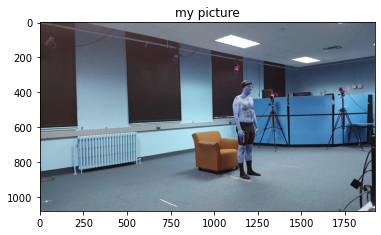

In [10]:
total_frames = cap.get(0)
ret, frame = cap.read()

plt.imshow(frame)
plt.title('my picture')
plt.show()

In [ ]:
class Ax3DPose(object):
    def __init__(
        self, ax, joints, lcolor="#3498db", rcolor="#e74c3c", ccolor="#2fb551"
    ):
        """
        Create a 3d pose visualizer that can be updated with new poses.
        Args
          ax: 3d axis to plot the 3d pose on
          lcolor: String. Colour for the left part of the body
          rcolor: String. Colour for the right part of the body
        """
        matplotlib.rcParams["animation.embed_limit"] = 200
        self.joints = joints
        # Start and endpoints of our representation
        self.I = np.array(
            [
                0,
                0,
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                9,
                9,
                12,
                13,
                14,
                16,
                17,
                18,
                19,
                20,
                22,
                23,
                20,
                25,
                26,
                20,
                28,
                29,
                20,
                31,
                32,
                20,
                34,
                35,
                21,
                37,
                38,
                21,
                40,
                41,
                21,
                43,
                44,
                21,
                46,
                47,
                21,
                49,
                50,
            ]
        )
        self.J = np.arange(1, 52)
        # Left / right indicator
        self.LR = np.ones(52, dtype=int)
        self.LR[
            [
                0,
                3,
                6,
                9,
                12,
                15,
                17,
                19,
                21,
                22,
                23,
                24,
                25,
                26,
                27,
                28,
                29,
                30,
                31,
                32,
                33,
                34,
                35,
            ]
        ] = 0
        self.LR[[2, 5, 8, 11, 14]] = 2
        self.ax = ax

        vals = np.zeros((52, 3))

        # Make connection matrix
        self.plots = []
        for i in np.arange(len(self.I)):
            x = np.array([vals[self.I[i], 0], vals[self.J[i], 0]])
            y = np.array([vals[self.I[i], 1], vals[self.J[i], 1]])
            z = np.array([vals[self.I[i], 2], vals[self.J[i], 2]])
            if self.LR[i] == 0:
                c = lcolor
            elif self.LR[i] == 1:
                c = rcolor
            else:
                c = ccolor

            self.plots.append(
                self.ax.plot(x, y, z, lw=3, c=c if self.LR[i] else rcolor)
            )

        self.ax.set_xlabel("x")
        self.ax.set_ylabel("y")
        self.ax.set_zlabel("z")

    def update(self, frame, lcolor="#3498db", rcolor="#e74c3c", ccolor="#2fb551"):
        """
        Update the plotted 3d pose.
        Args
          channels: 96-dim long np array. The pose to plot.
          lcolor: String. Colour for the left part of the body.
          rcolor: String. Colour for the right part of the body.
        Returns
          Nothing. Simply updates the axis with the new pose.
        """
        vals = self.joints[frame]
        for i in np.arange(len(self.I)):
            x = np.array([vals[self.I[i], 0], vals[self.J[i], 0]])
            y = np.array([vals[self.I[i], 1], vals[self.J[i], 1]])
            z = np.array([vals[self.I[i], 2], vals[self.J[i], 2]])
            self.plots[i][0].set_xdata(x)
            self.plots[i][0].set_ydata(y)
            self.plots[i][0].set_3d_properties(z)
            if self.LR[i] == 0:
                c = lcolor
            elif self.LR[i] == 1:
                c = rcolor
            else:
                c = ccolor
            self.plots[i][0].set_color(c)

        r = 1 if np.max([vals[0, 0], vals[0, 1], vals[0, 2]]) <= 10 else 1000
        xroot, yroot, zroot = vals[0, 0], vals[0, 1], vals[0, 2]
        self.ax.set_xlim3d([-r + xroot, r + xroot])
        self.ax.set_zlim3d([-r + zroot, r + zroot])
        self.ax.set_ylim3d([-r + yroot, r + yroot])


def play_motion(joints):
    fig = plt.figure()
    ax = plt.gca(projection="3d")
    ob = Ax3DPose(ax, joints)

    for j in range(joints.shape[0]):
        ob.update(j)
        plt.show(block=False)
        fig.canvas.draw()
        plt.pause(1.0 / 120)
    plt.close()
    return anim.to_jshtml()

In [ ]:
play_motion(joints)

In [ ]:
play_motion(joints)